In [1]:
using Revise

In [2]:
#using PyPlot
using Plots
using BenchmarkTools
using DifferentialEquations
using Land
using Land.Photosynthesis

output_dir = joinpath(@__DIR__,"..","output")
mkpath(output_dir)

┌ Info: Precompiling Land [27e3c115-2cb8-4114-b7a5-cd9f011f9dcc]
└ @ Base loading.jl:1273


Reading Optical Parameters from 400.0 to 2380.0 length: 115


"/Users/cfranken/Google Drive/work/code/GitHub/Land/notebooks/../output"

In [3]:
const FT = Float32

mods = Photosynthesis.PhotoMods(
    fluorescence    = FlexasTolBerryFluorescence{FT}(),
    photosynthesis  = C3FvCBPhotoGs(),
    respiration     = RespirationCLM{FT}(),
    stomatal        = GentineStomata{FT}(),
    Jmax            = JmaxCLM{FT}(),
    Vmax            = VcmaxCLM{FT}(),
    MichaelisMenten = MM_CLM{FT}(),
    BoundaryLayer   = GentineLeafBoundary())

# Create a leaf structure
l = leaf_params{Float32}();

# Create a meteo structure
met = meteo{Float32}();

#met = meteo();

# initialize some reasonable values
#f.Je   = 100; f.gbc  = 100; f.gbv  = 100; f.ceair= 1500; f.eair = 1500; f.APAR = 500; f.H=0;f.LE=0; # leaf should not have eair
l.Kn = 2.44; l.α=0.2; l.ε=0.98; l.LMA=100e-3; l.RWC=80/100;l.psi_l=-1e6;l.psi_l50 = -1e6;l.ck=3;met.zscreen = 2.0;
l.height   = 1.0; met.zscreen  = 2.0;
met.stab_type_stable = 2;
l.gstyp = 3;

met.e_air = 1500;

l.Kn = 2.44; l.α=0.2; l.ε=0.98; l.LMA=100e-3; l.RWC=80/100;l.psi_l=-1e6;l.psi_l50 = -1e6;l.ck=3;met.zscreen = 2.0;
l.height   = 1.0; met.zscreen  = 2.0;
met.stab_type_stable = 2;
l.dynamic_state = true;

In [4]:

# A diurnal cycle for radiation and Tair
Deltat  = 60;
Samp    = 500; # W/m2 amplitude
Tmean   = 273.15+22;
DeltaT  = 3;
omega   = 2*π/(24*3600);
t       = range(0, stop=24*3600, step=Deltat); # diurnal cycle in seconds
#print(t)
phi_t   = omega*t-π*ones(size(t))/2;
Sdown_t = zeros(size(t));
Tair_t  = zeros(size(t));
zeros_t = zeros(size(t));
for i = 1:length(Sdown_t)
    Sdown_t[i] = Samp*max( sin(phi_t[i]),zeros_t[i] );#max(sin(phase[i]),zeros(size(t[i])));
    Tair_t[i]  = Tmean + DeltaT*sin(phi_t[i]-π/3);
end


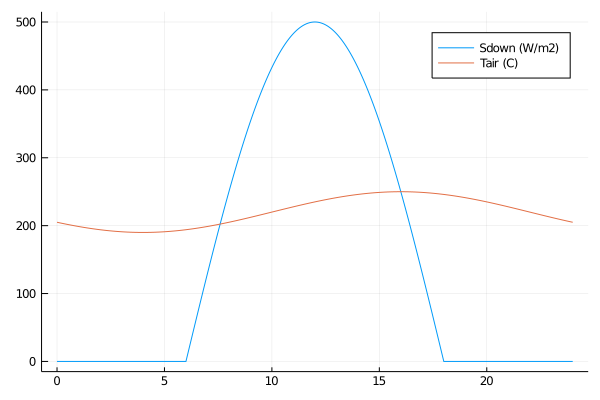

In [5]:
plot(t/3600,Sdown_t,label="Sdown (W/m2)")
plot!(t/3600,10*(Tair_t-273.15*ones(size(Tair_t))),label="Tair (C)")

In [39]:
psi_s      = -0.5e6 ; # soil water potential (Pa)
U          =  1.0;
RH         =  65/100;
eps_air    =  0.75;
tspan      =  (0.0,Deltat);
N          =  length(Sdown_t);
mutable struct parameters_ode
    l::leaf_params;
    met::meteo;
    psi_s;
end

In [76]:
# small time stepping
dt     = 0.1*60; # in s
T_t    = zeros(size(Sdown_t));
sif_yield = similar(T_t)
φ_t= similar(T_t)
psil_t = zeros(size(Sdown_t));
Cc_t   = zeros(size(Sdown_t));
Rn_t   = zeros(size(Sdown_t));
GPP_t  = zeros(size(Sdown_t));
GPP_diffusion_t  = zeros(size(Sdown_t));
LUE_t  = zeros(size(Sdown_t));
H_t    = zeros(size(Sdown_t));
LE_t   = zeros(size(Sdown_t));
rs_t   = zeros(size(Sdown_t));
ra_t   = zeros(size(Sdown_t));
gs_t   = zeros(size(Sdown_t));
apar = zeros(size(Sdown_t));

function f_ode!(du,u,p,t) # p are parameters
    du .= LeafEnergyWaterBalance(mods,u[1], u[2], u[3], p.met, p.l, p.psi_s);
    #println("du_inside = $(du), u_inside = $(u)")
end

let
    # initial conditions
    met.T_air  = Tair_t[1];
    l.T        = met.T_air;
    l.psi_l    = psi_s;
    l.Cc       = 0.6*met.Ca;
    #println("Tair1=",met.T_air," Tleaf1=",l.T," psi_leaf1=",l.psi_l)
        
    for i=1:N
        met.S_down = Sdown_t[i];
        met.L_down = eps_air*physcon.σ*(Tair_t[i])^4;
        met.T_air  = Tair_t[i];
        met.e_air  = RH*SatVap(Tair_t[i])[1];
        met.PAR    = 45/100*physcon.Wtoμmole_s*Sdown_t[i];
        l.APAR     = met.PAR;
        met.U      = U;
        met.Ca     = 400.0; #ppm
        l.APAR     = met.PAR;
        #println("Tair=",met.T_air," Tleaf=",l.T," psi_leaf=",l.psi_l)
        for j=1:trunc(Deltat/dt)
            u    = [l.T;l.psi_l;l.gs];
            p    = parameters_ode(l,met,psi_s);
            #(p.met, p.l,  p.psi_s, p.U)    = [l;met;psi_s;U];
            #prob = ODEProblem(f_ode!,u0,tspan,p);
            #du   = zeros(size(u));
            #f_ode!(du,u,p,t,dummy);
            #println("du_outside = $(du), u_outside = $(u)")
            # Rn_t[i] = dummy[3]; H_t[i] = dummy[4]; LE_t[i] = dummy[5];
            
            
            du   = zeros(size(u));
            f_ode!(du,u,p,t);
            #@show du
            #@show u
            (l.T,l.psi_l,l.gs) = du*dt+u;
            #@show p.l.gs
            #println("Cc_out=",l.Cc)
            Rn_t[i] = p.l.Rn; H_t[i] = p.l.H; LE_t[i] = p.l.LE; 
            gs_t[i] = p.l.gs;
            φ_t[i] = p.l.φ;
            sif_yield[i] = l.ϕs
            rs_t[i] = 1.0/(p.l.gs/p.met.g_m_s_to_mol_m2_s); 
            ra_t[i] = p.met.ra; 
            GPP_t[i]= p.l.An; 
            GPP_diffusion_t[i]= p.l.An; 
            LUE_t[i]= p.l.An/l.APAR; 
            apar[i]=l.APAR;
            #T_old   = l.T;
            #(l.T,l.psi_l) = du*dt+u;
            T_t[i]    = l.T ; #  = T_old; 
            psil_t[i] = l.psi_l;
            Cc_t[i]   = l.Cc;
            
            if(abs(H_t[i])>500)
                println("index ($i) ($j)")
            end         
        end
    end
end


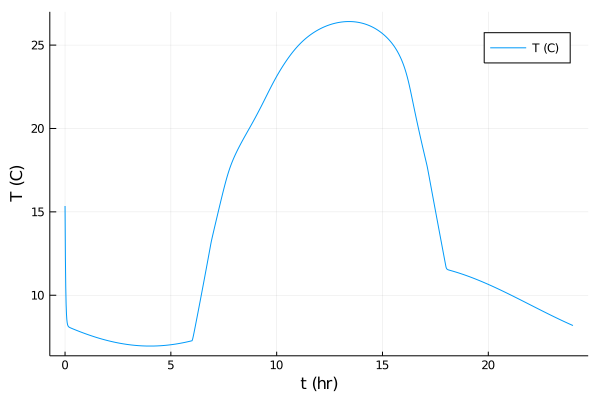

In [77]:
plot(t/3600, T_t-273.15*ones(size(T_t)),xlabel = "t (hr)",ylabel = "T (C)",label="T (C)",ylim=0:100)

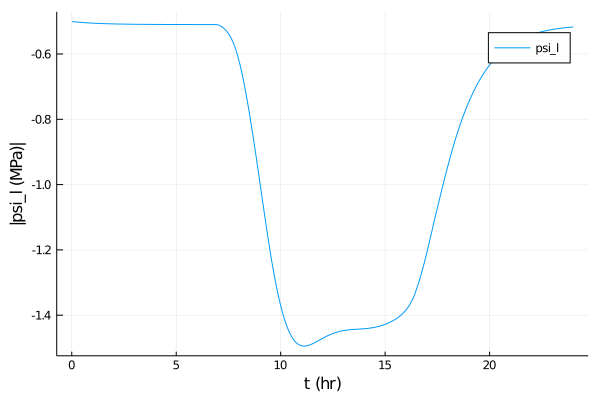

In [78]:
plot(t/3600,psil_t/1e6,xlabel = "t (hr)",ylabel = "|psi_l (MPa)|",label="psi_l",ylim=0:100)

In [79]:
savefig(joinpath(output_dir, "T_psi_diurnal_t.png"))

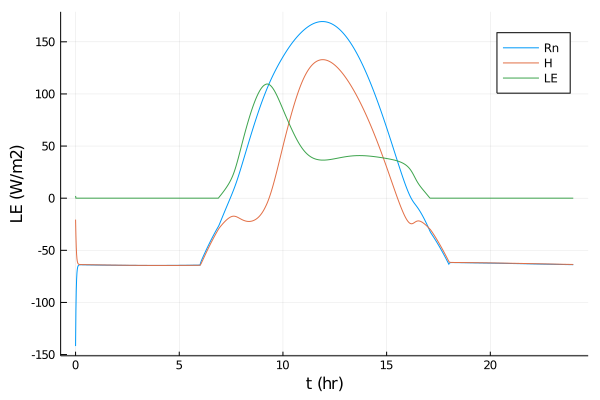

In [80]:
plot(t/3600,  Rn_t,xlabel = "t (hr)",ylabel = "Rn (W/m2)",label="Rn")
plot!(t/3600, H_t,xlabel  = "t (hr)",ylabel = "H (W/m2)" ,label="H")
plot!(t/3600, LE_t,xlabel = "t (hr)",ylabel = "LE (W/m2)",label="LE")

In [81]:
savefig(joinpath(output_dir, "Fluxes_diurnal_t.png"))

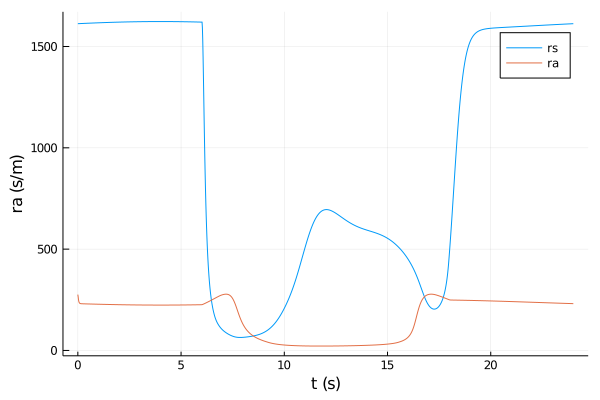

In [82]:
plot(t/3600,  rs_t,xlabel = "t (s)",ylabel = "rs (s/m)",label="rs")
plot!(t/3600, ra_t,xlabel  = "t (s)",ylabel = "ra (s/m)" ,label="ra")

In [83]:
savefig(joinpath(output_dir, "resistances_diurnal_t.png"))

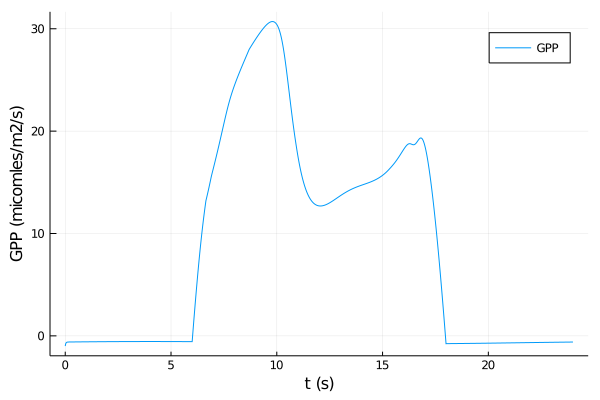

In [84]:
plot(t/3600, GPP_t,xlabel = "t (s)",ylabel = "GPP (micomles/m2/s)",label="GPP",ylim=0:100)

In [85]:
savefig(joinpath(output_dir, "GPP_diurnal_t.png"))

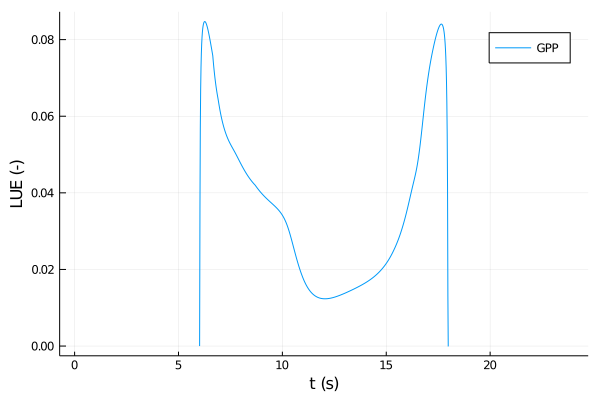

In [86]:
plot(t/3600, max.(0,GPP_t)./apar,xlabel = "t (s)",ylabel = "LUE (-)",label="GPP",ylim=0:100)

In [87]:
savefig(joinpath(output_dir, "LUE_diurnal_t.png"))

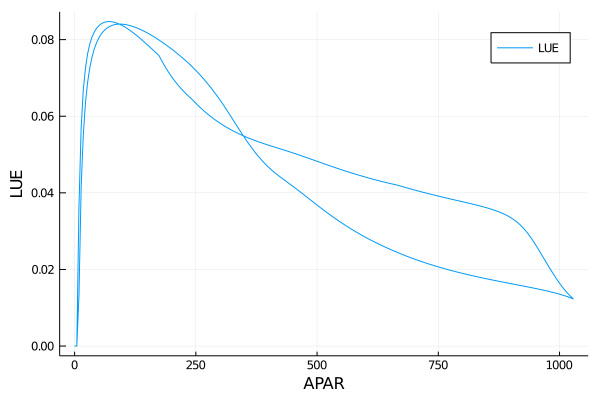

In [88]:
plot(apar, max.(0,GPP_t)./apar,xlabel = "APAR",ylabel = "LUE",label="LUE",ylim=0:100)

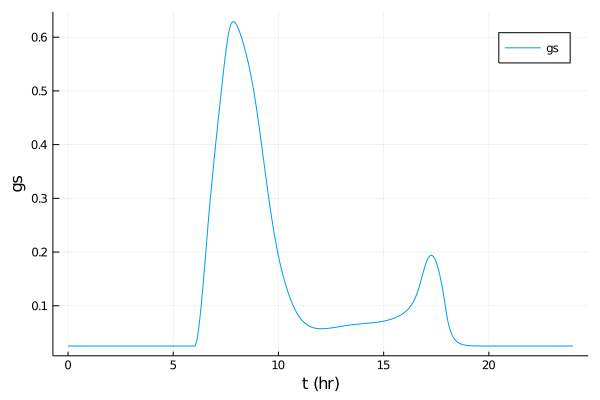

In [89]:
plot(t/3600, gs_t, xlabel = "t (hr)",ylabel = "gs",label="gs")

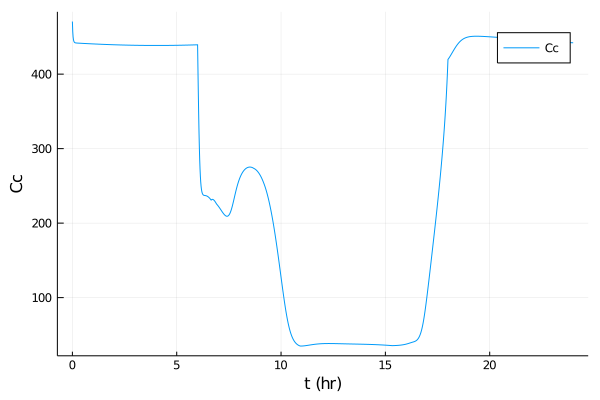

In [90]:
plot(t/3600, Cc_t,xlabel = "t (hr)",ylabel = "Cc",label="Cc")

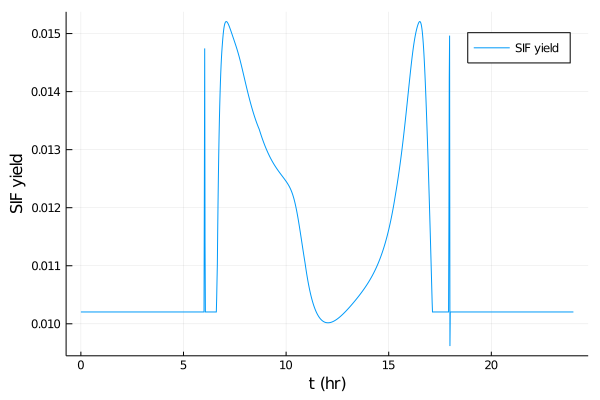

In [91]:
plot(t/3600, sif_yield,xlabel = "t (hr)",ylabel = "SIF yield",label="SIF yield")

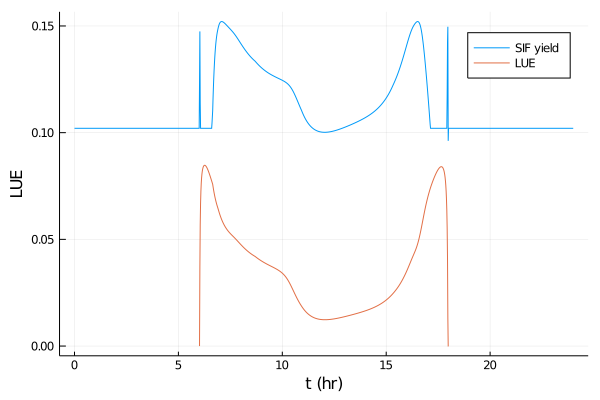

In [92]:
plot(t/3600, 10sif_yield,xlabel = "t (hr)",ylabel = "SIF yield",label="SIF yield")
plot!(t/3600, max.(0,GPP_t)./apar,xlabel = "t (hr)",ylabel = "LUE",label="LUE")

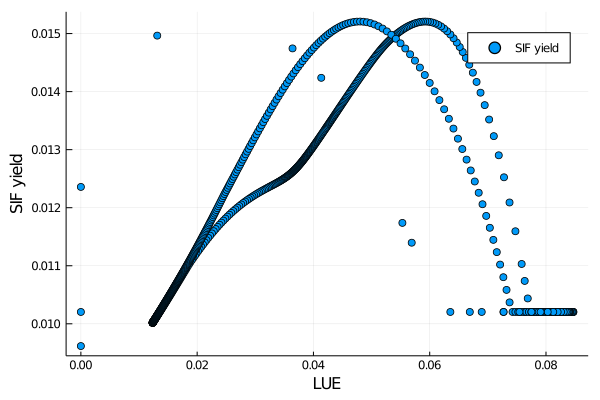

In [93]:
scatter(max.(0,GPP_t)./apar, sif_yield,xlabel = "LUE",ylabel = "SIF yield",label="SIF yield")
#plot!(t/3600, max.(0,GPP_t)./apar,xlabel = "t (hr)",ylabel = "LUE",label="LUE")

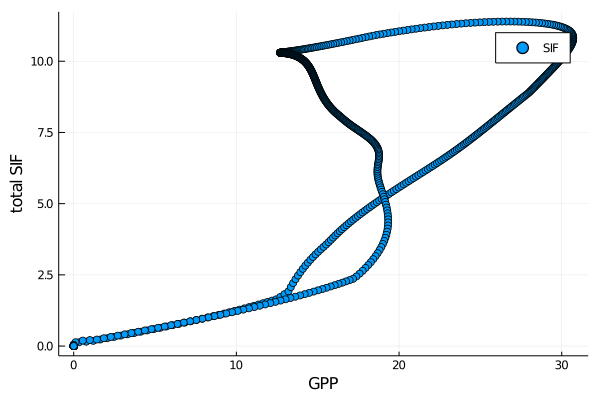

In [94]:
scatter(max.(0,GPP_t), sif_yield.*apar,xlabel = "GPP",ylabel = "total SIF",label="SIF")

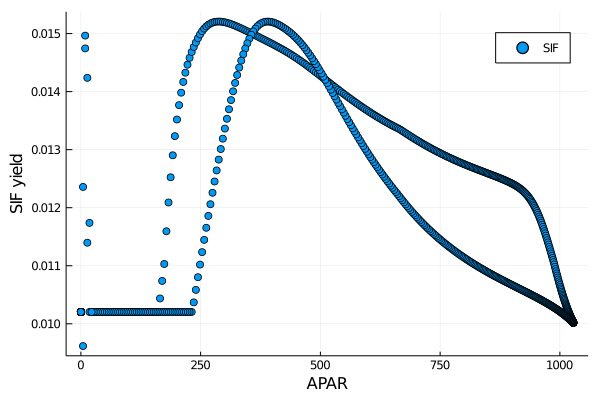

In [95]:
scatter(apar, sif_yield,xlabel = "APAR",ylabel = "SIF yield",label="SIF")

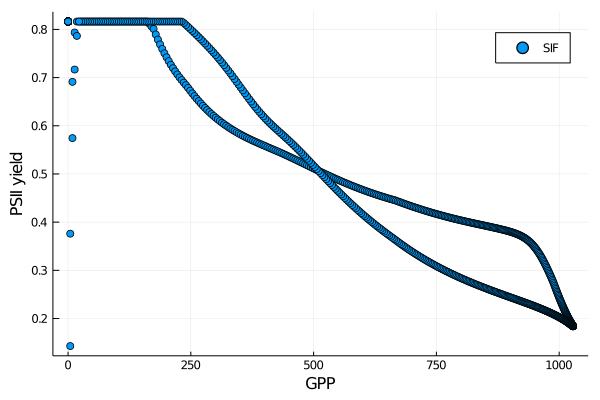

In [96]:
scatter(apar, φ_t,xlabel = "GPP",ylabel = "PSII yield",label="SIF")

In [97]:
l.APAR = 100
LeafPhotosynthesis!(mods, l,met)
@show l.φ
@show l.Ac
@show l.Aj
@show l.Ap
@show l.ϕs
@show l.NPQ
@show l.Cc
@show l.Vcmax25

l.φ = 0.65201414f0
l.Ac = 5.663952f0
l.Aj = 5.5768466f0
l.Ap = 9.9347725f0
l.ϕs = 0.015147419f0
l.NPQ = 0.2762933f0
l.Cc = 32.170715f0
l.Vcmax25 = 80.0f0


80.0f0

ErrorException: type DataType has no field psi_s

In [38]:
l.psi_l50

-1.0f6